In [329]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [330]:
class Value:
    def __init__(self, data, _children=(), _op='',label=""):
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self.data = data
        self._op = _op
        self._backward = lambda: None


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data + other.data, (self, other),"+")
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), "exp")

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out

    
    def tanh(self):
        out = Value(np.tanh(self.data), (self,), "tanh")
        def _backward():
            self.grad += out.grad * (1 - out.data**2)
        out._backward = _backward
        return out 
    
    def backward(self):
        topo = []
        visited_nodes = set()

        self.grad=1.0


        def topo_sort(node):
            if node not in visited_nodes:
                visited_nodes.add(node)
                for child in node._prev:
                    topo_sort(child)
                topo.append(node)

        topo_sort(self)

        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * Value(-1.0)

    def __sub__(self, other): # self - other
        return self + (-other)

    def __pow__(self, n):
        assert isinstance(n, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**n, (self,), f"**{n}")

        def _backward():
            self.grad += n * self.data**(n-1) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

In [331]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape="record")
    if n._op:
      uid_op = uid + n._op
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid_op, label = n._op)
      # and connect this node to it
      dot.edge(uid_op, uid)

  for n1, n2 in edges:
  #   # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2))+n2._op)

  return dot




In [332]:
x1 = Value(2.0); x1.label="x1"
x2 = Value(0.0); x2.label="x2"

w1 = Value(-3.0); w1.label="w1"
w2 = Value(1.0); w2.label="w2"

x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"

b = Value(6.8813); b.label="b" 

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1x2w2"
n = x1w1x2w2 + b; n.label="n"
# o = n.tanh();o.label="o"
# tanh = e^2x - 1 / e^2x + 1
e = (2*n).exp();e.label="e"
o = (e-1)/(e+1);o.label="o"


In [333]:
o.backward()

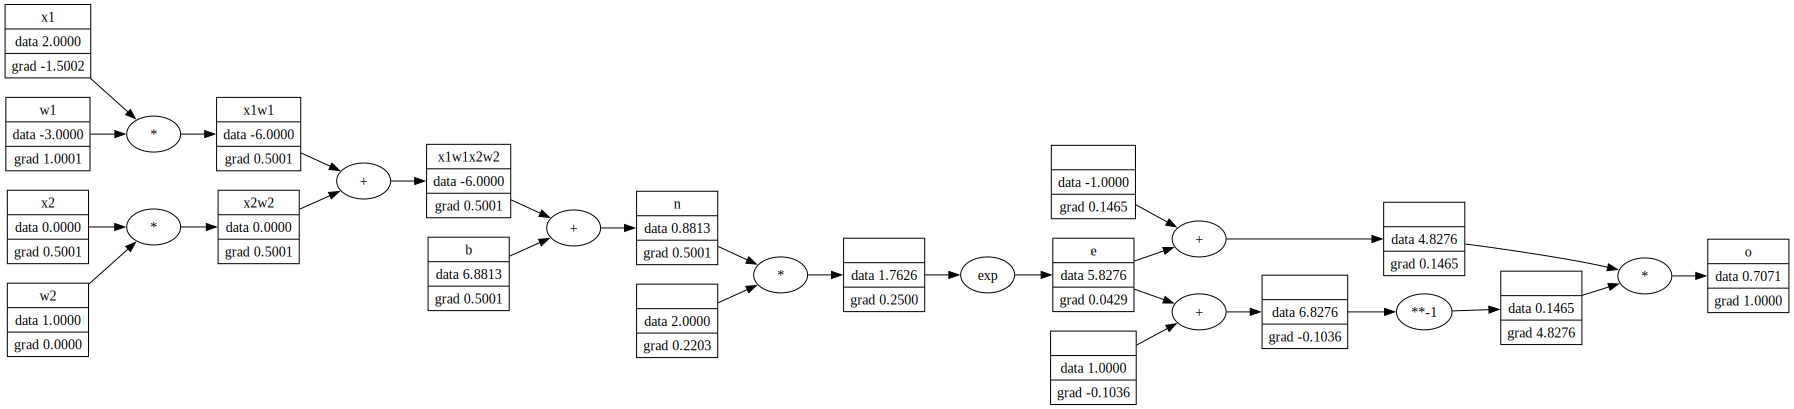

In [334]:
draw_dot(o)

In [335]:
import torch

In [336]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813]).double(); b.requires_grad=True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.backward()

print(x1.grad, x2.grad, w1.grad, w2.grad, b.grad)


tensor([-1.5002], dtype=torch.float64) tensor([0.5001], dtype=torch.float64) tensor([1.0001], dtype=torch.float64) tensor([0.], dtype=torch.float64) tensor([0.5001], dtype=torch.float64)


In [337]:
import random

In [338]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1)) 

    def __call__(self,x):   
        act = sum((wi*xi for xi,wi in zip(x,self.w)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs


In [339]:
x=[2.0,3.0]
n = Layer(2,3)
n(x)           

[Value(data=0.19655830058226836),
 Value(data=0.9599936975880015),
 Value(data=0.9989871316817621)]